In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
# import zipfile

In [4]:
## Checking Versions
# print(f' Keras version={tf.keras.__version__}')
# print(f' Tensorflow version={tf.__version__}')
# # !pip list | grep keras-hub
# !pip show keras-hub

In [5]:
noted_path = os.getcwd()
noted_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project'

### **Helper Functions**

In [6]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

**<span style="color:#180842; font-size:26px">
New Train/Validation Data - Based on Test Set
</span>** <br>

In [7]:
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"
# test_dataset_url = "https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1?"
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/kl3e9wxoibqu0ldogwxg0/test_google_images_landslides_five.zip?rlkey=zuhh6xvjy3oi9wuroy4ogtdi3&dl=0?raw=1"

In [8]:
data_dir_two = tf.keras.utils.get_file('test_google_images_landslides_five.zip', origin=test_dataset_url, extract=True)
data_dir_two = pathlib.Path(data_dir_two).with_suffix('')

In [9]:
## Review folders in incoming data / classes
folders_two = [folder for folder in data_dir_two.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders_two:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images
Test_Images_Duplicates


In [10]:
# Drill into each subdirectory and list files
total_files = 0
for folder in folders_two:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")
            total_files += count  # Add the count of .jpg images to the total
            
# Print the total number of files
print(f"\nTotal number of files: {total_files}")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 65 .jpg images
  Subfolder: non-landslides
non-landslides: 77 .jpg images
  File: .DS_Store

Contents of folder 'Test_Images_Duplicates':
  File: nasa_g_4263m_12654_2023_cat.jpg
  File: nasa_g_3015m_12654_2023_cat.jpg
  File: nasa_g_4161m_11542_2021_cat.jpg
  File: nasa_g_2785m_11542_2021_cat_town.jpg
  File: nasa_g_4800m_10029_2019_vylg.jpg
  File: nasa_g_4800m_9304_2017_vylg.jpg
  File: nasa_g_4250m_12699_2019_large_v2.jpg

Total number of files: 142


In [11]:
print(data_dir_two)

/home/waa4bq/.keras/datasets/test_google_images_landslides_five_extracted


In [12]:
## Update Directory
data_dir_two_alt_path = '/home/waa4bq/.keras/datasets/test_google_images_landslides_five_extracted/Google_Earth_Images'
print(data_dir_two_alt_path)

/home/waa4bq/.keras/datasets/test_google_images_landslides_five_extracted/Google_Earth_Images


**<span style="color:#180842; font-size:26px">
Set Training/Validation Data & Split
</span>** <br>

In [13]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [14]:
## Set Training Set image set. 
train_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.2,
  subset="training",
  seed=910,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 142 files belonging to 2 classes.
Using 114 files for training.


2024-12-09 22:25:50.381763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43482 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:04:00.0, compute capability: 8.6


In [15]:
## Setup Valiation set.
valid_dataset_two = tf.keras.utils.image_dataset_from_directory(
  data_dir_two_alt_path,
  validation_split=0.2,
  subset="validation",
  seed=910,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 142 files belonging to 2 classes.
Using 28 files for validation.


In [16]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset_two.unbatch())
valid_count = sum(1 for _ in valid_dataset_two.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset_two, train_class_counts)
count_classes(valid_dataset_two, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

2024-12-09 22:25:52.033222: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-09 22:25:52.088656: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set size: 114
Validation set size: 28

Class distribution in Training set:
  Class 0: 50 samples
  Class 1: 64 samples

Class distribution in Validation set:
  Class 0: 15 samples
  Class 1: 13 samples


2024-12-09 22:25:52.270849: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### **Buffering/Shuffle**

In [17]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_two = train_dataset_two.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
valid_dataset_two = valid_dataset_two.cache().prefetch(buffer_size=AUTOTUNE)

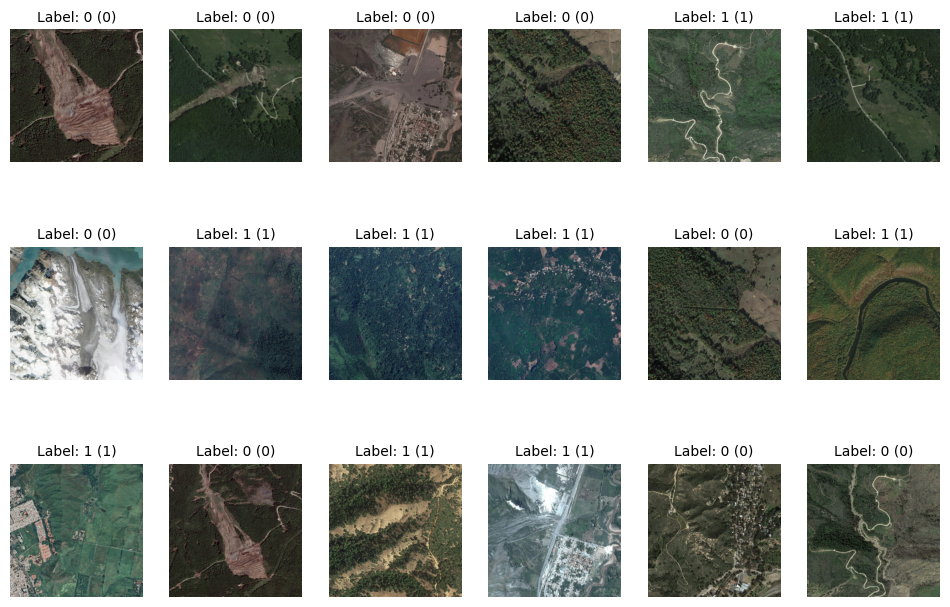

In [18]:
## Checking Images and Labels:
plt.figure(figsize=(12, 8))
for images, labels in train_dataset_two.take(1):  # Take one batch
    for i in range(18):  # Display first 6 samples
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #301b66">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [19]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset_two])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict_goog = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict_goog)

Class weights: {0: 1.14, 1: 0.890625}


#### **Visualization Helper**

In [59]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']
    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(7, 10), dpi=150)
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='#0c3d5d', linestyle='--')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#e52e22', linestyle='-.')  
    plt.legend(loc='lower right')
    plt.title('Re-Trained EfficientNetB3: Training and Validation Accuracy')
    plt.xlabel('Epochs')  # Add x-axis label

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('EfficientNetB3 Training and Validation Loss')
    plt.xlabel('Epochs')  # Add x-axis label
    # Adjust layout to add space between graphs
    plt.subplots_adjust(hspace=0.3)  # Adjusts vertical space (0.5 can be adjusted as needed)
    
    plt.show()

#### **Augmentation Helper**

In [21]:
### Data Augmentation Helper
data_augmentation = keras.Sequential(
  [
#     keras.layers.RandomRotation(factor=0.40),
#     keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect"),
#     keras.layers.RandomFlip("horizontal_and_vertical"),
#     keras.layers.RandomCrop(300, 300, input_shape=(350, 350, 3)),
#     keras.layers.RandomContrast(factor=0.6), ## Values closer to 0 = minimal adjustment, higher to 1.0 allow larger contrast variations.
#     keras.layers.RandomBrightness(factor=.6),
      
#     # layers.RandomSaturation(.7, seed=516) ## Error
#     keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.7, upper=1.3))
#   ]
# )

    keras.layers.Input(shape=(350, 350, 3)),  # Explicit Input layer
    keras.layers.RandomRotation(factor=0.40),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="reflect"),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomCrop(300, 300),
    keras.layers.RandomContrast(factor=0.6),  # Values closer to 0 = minimal adjustment, higher to 1.0 allow larger contrast variations.
    keras.layers.RandomBrightness(factor=0.6),
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.7, upper=1.3))
  ]
)

<hr style="border:12px solid #301b66">

**<span style="color:#0638b2; font-size:28px">
Phase II Keras Landslide Model for Further Training
</span>** <br>


##### **Rebuild Helper w/ Augmentation**

In [22]:
# def build_phTwo_model(loaded_model, num_classes, learn_rate_land=1e-3):
#     inputs = layers.Input(shape=(img_height, img_height, 3))
       
#     ### Adding Augmentation
#     augmented_inputs = data_augmentation(inputs, training=True)  ## Added Line
    
#     # phTwo_base_model = tf.keras.Model(loaded_model.input, loaded_model.layers[-1].input)  # Exclude only the last layer
#     # phTwo_base_model = tf.keras.Model(loaded_model.input, loaded_model.layers[-1].input)  # Include all layers except top
    
#     ### Rebuild the entire pre-trained model as individual layers
#     x = augmented_inputs
#     for layer in loaded_model.layers:
#         x = layer(x)  # Pass inputs through each layer of the pre-trained model
    
# #     # Pass augmented inputs through the entire loaded model
# #     x = loaded_model(augmented_inputs)

# #     loaded_model.trainable = False
    
# #     # Pass augmented inputs through the base model
# #     # x = phTwo_base_model(augmented_inputs)
    
#     # Add new top layers
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.2, name="top_dropout")(x)
#     outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

#     # Compile the modified model
#     model = tf.keras.Model(inputs, outputs, name="ModifiedEfficientNet")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate_land)
#     model.compile(
#         optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
#     )
#     return model

#### **Fine-Tuning Helper**

In [23]:
## Define Unfreeze Model method to open up layers for further training. 
def unfreeze_model(model, layer_num, learning_rate):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-(layer_num+1):]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    # optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
    # optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    # optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
    
    return model

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:22px">
Load Landslide Pre-trained Model
</span>** <br>

In [24]:
### Create path to saved model. 
reconstruct_path = (f'{noted_path}/ENB3_One_40Lyr_hh.keras')
reconstruct_path

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project/ENB3_One_40Lyr_hh.keras'

In [25]:
### Build model based on saved model. 
reconst_ENB3 = keras.models.load_model(reconstruct_path)

In [26]:
# Freeze all layers
for layer in reconst_ENB3.layers:
    layer.trainable = False


**Check to see which layers are open**

In [27]:
### Check layer Open Changes...
print(f' Number of layers {len(reconst_ENB3.layers)}')
# reconst_ENB3.summary(show_trainable=True)

 Number of layers 389


<hr style="border:4px solid #301b66">

**<span style="color:#0638b2; font-size:20px">
Utilize Fully Closed Landslide Tuned Model
</span>** <br>

In [28]:
### Set new params.
layer_open = 10
land_lr = 1e-3
### Rebuild new model. 
ls_model_phTwo_model = unfreeze_model(reconst_ENB3, layer_num=layer_open, learning_rate=land_lr)

In [29]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

In [30]:
### Set up Augmentation method to apply Image Aug. 
# train_dataset_two_augmented = train_dataset_two.map(lambda x, y: (data_augmentation(x), y))

# Apply data augmentation to the training dataset
train_dataset_two_augmented = train_dataset_two.shuffle(buffer_size=200).map(lambda x, y: \
                                  (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
epochs = 10  # @param {type: "slider", min:8, max:80}

PhaseII_ENB3_hist = ls_model_phTwo_model.fit(train_dataset_two_augmented, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/10


I0000 00:00:1733801198.738752  562661 service.cc:146] XLA service 0x7f2fa00035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733801198.738821  562661 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-12-09 22:26:39.103324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 22:26:40.379046: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


1/4 ━━━━━━━━━━━━━━━━━━━━ 1:02 21s/step - accuracy: 0.6667 - loss: 1.6666

I0000 00:00:1733801211.767464  562661 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.5942 - loss: 2.0146 - val_accuracy: 0.5000 - val_loss: 4.0601
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.6583 - loss: 1.4086 - val_accuracy: 0.5714 - val_loss: 1.6092
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.6876 - loss: 0.8117 - val_accuracy: 0.5714 - val_loss: 1.3111
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.7943 - loss: 0.5978 - val_accuracy: 0.6071 - val_loss: 1.0556
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - accuracy: 0.8333 - loss: 0.4233 - val_accuracy: 0.5714 - val_loss: 1.0741
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.7438 - loss: 0.6574 - val_accuracy: 0.5357 - val_loss: 1.1869
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.8441 - loss: 0.4506 - val_accuracy: 0.6429 - val_loss: 1.2513
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.8065 - loss: 0.4709 - val_accuracy: 0.5714 - val_loss: 1.3028
Epoch

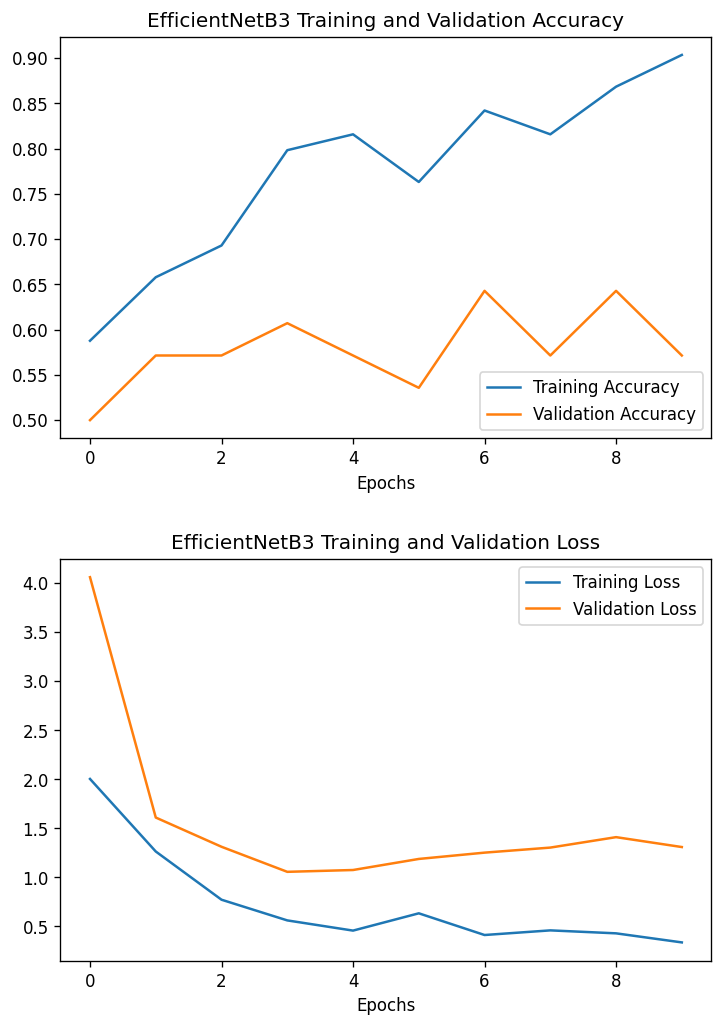

In [37]:
## Plot results
visualize_model_results(PhaseII_ENB3_hist)

<hr style="border:4px solid #301b66">

**<span style="color:#0638b2; font-size:22px">
Further Train on Open Layers w/ New Data
</span>** <br>

**<span style="color:#0638b2; font-size:15px">
Layer Option 1
</span>** <br>

In [ ]:
### Build model based on saved model. 
reconst_ENB3 = keras.models.load_model(reconstruct_path)

In [ ]:
# Freeze all layers
for layer in reconst_ENB3.layers:
    layer.trainable = False

In [ ]:
### Rebuild new model. 
layer_open = 60  ## ENB3-40 60 layers did well with LR 1e-3, not so well with 1e-4; ENB3-15 
land_lr = 1e-3
ls_model_phTwo_model = unfreeze_model(reconst_ENB3, layer_num=layer_open, learning_rate=land_lr)

In [ ]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

In [ ]:
# Apply data augmentation to the training dataset
train_dataset_two_augmented = train_dataset_two.shuffle(buffer_size=200).map(lambda x, y: \
                                  (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
epochs = 30  # @param {type: "slider", min:8, max:80}

PhaseII_ENB3_hist = ls_model_phTwo_model.fit(train_dataset_two_augmented, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

In [ ]:
## Plot results
visualize_model_results(PhaseII_ENB3_hist)

In [ ]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

<hr style="border:3px solid #301b66">

**<span style="color:#0638b2; font-size:15px">
Layer Option 2
</span>** <br>

In [38]:
### Build model based on saved model. 
reconst_ENB3 = keras.models.load_model(reconstruct_path)

In [39]:
# Freeze all layers
for layer in reconst_ENB3.layers:
    layer.trainable = False

In [40]:
### Rebuild new model. 
layer_open = 40
land_lr = 1e-3
ls_model_phTwo_model = unfreeze_model(reconst_ENB3, layer_num=layer_open, learning_rate=land_lr)

In [41]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

In [42]:
### Set up Augmentation method to apply Image Aug. 
# train_dataset_two_augmented = train_dataset_two.map(lambda x, y: (data_augmentation(x), y))

# Apply data augmentation to the training dataset
train_dataset_two_augmented = train_dataset_two.shuffle(buffer_size=200).map(lambda x, y: \
                                  (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
epochs = 20  # @param {type: "slider", min:8, max:80}

PhaseII_ENB3_hist = ls_model_phTwo_model.fit(train_dataset_two_augmented, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

Epoch 1/20


E0000 00:00:1733801652.348671  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733801652.474805  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733801652.659877  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733801652.790242  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733801653.208443  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

1/4 ━━━━━━━━━━━━━━━━━━━━ 59s 20s/step - accuracy: 0.6250 - loss: 2.1368

E0000 00:00:1733801663.019876  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733801663.143115  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733801663.491282  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733801663.623824  562661 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.5314 - loss: 3.6655 - val_accuracy: 0.4643 - val_loss: 2.1797
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.5621 - loss: 1.5472 - val_accuracy: 0.5357 - val_loss: 1.3464
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.5560 - loss: 1.0230 - val_accuracy: 0.5357 - val_loss: 0.9845
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.7361 - loss: 0.6413 - val_accuracy: 0.5000 - val_loss: 0.7242
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.7690 - loss: 0.5859 - val_accuracy: 0.6071 - val_loss: 0.7283
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.7884 - loss: 0.5030 - val_accuracy: 0.6071 - val_loss: 0.7606
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.7724 - loss: 0.4863 - val_accuracy: 0.5000 - val_loss: 0.9244
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.8623 - loss: 0.3645 - val_accuracy: 0.6071 - val_loss: 1.0688
Epoch

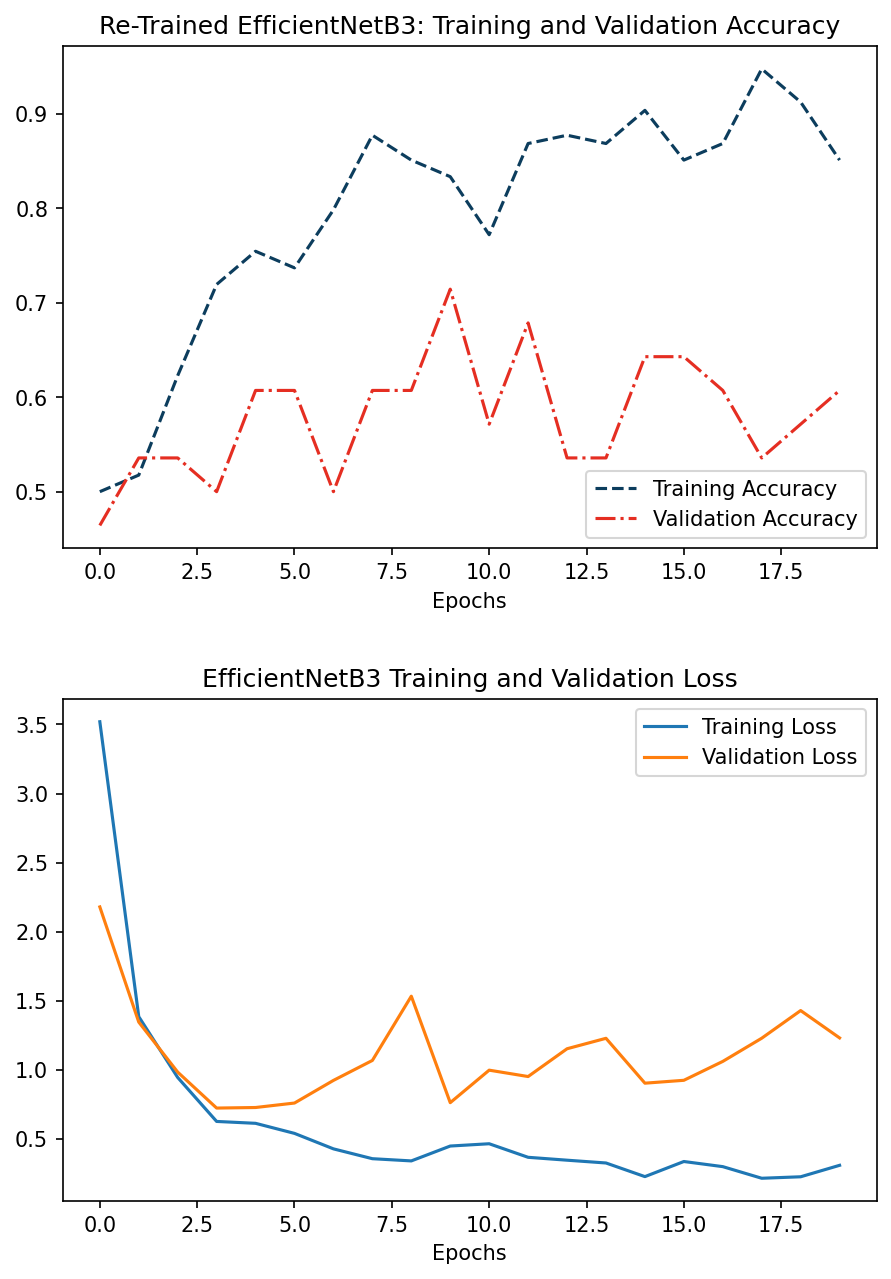

In [60]:
## Plot results
visualize_model_results(PhaseII_ENB3_hist)

<hr style="border:3px solid #301b66">

**<span style="color:#0638b2; font-size:15px">
Layer Option 3
</span>** <br>

In [ ]:
### Build model based on saved model. 
reconst_ENB3 = keras.models.load_model(reconstruct_path)

In [ ]:
# Freeze all layers
for layer in reconst_ENB3.layers:
    layer.trainable = False

In [ ]:
### Rebuild new model. 
layer_open = 70   ## Does better than 60
land_lr = 1e-3
ls_model_phTwo_model = unfreeze_model(reconst_ENB3, layer_num=layer_open, learning_rate=land_lr)

In [ ]:
### Check layer Open Changes...
# ls_model_phTwo_model.summary(show_trainable=True)

In [ ]:
### Set up Augmentation method to apply Image Aug. 
# train_dataset_two_augmented = train_dataset_two.map(lambda x, y: (data_augmentation(x), y))

# Apply data augmentation to the training dataset
train_dataset_two_augmented = train_dataset_two.shuffle(buffer_size=200).map(lambda x, y: \
                                  (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
epochs = 30  # @param {type: "slider", min:8, max:80}

PhaseII_ENB3_hist = ls_model_phTwo_model.fit(train_dataset_two_augmented, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

In [ ]:
## Plot results
visualize_model_results(PhaseII_ENB3_hist)

<hr style="border:3px solid #301b66">

### **Extract Only Certain Layers and Build New Model**
- Very difficult

In [ ]:
IMG_SIZE=300

In [ ]:
## Extract layers from prior model:
extracted_layers = reconst_ENB3.layers[-32:-1]

In [ ]:
model_temp = keras.Sequential(extracted_layers)

In [ ]:
model_temp.summary()

In [ ]:
# ls_model_ph_two_top = tf.keras.Sequential([
    # data_augmentation,  ## Data Augmentation

ls_model_phTwo_model = Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu'),  # Reduce size
    keras.layers.MaxPooling2D(pool_size=(2, 2)), # Further reduce
    keras.layers.Conv2D(1392, (3, 3), strides=(7, 7), padding="same", activation='relu'), # Increase channels to 1392
    keras.layers.Conv2D(1392, (3, 3), strides=(1, 1), padding="valid", activation='relu'), # 10x10x1392
    keras.layers.Reshape((10, 10, 1392)),
    
    *reconst_ENB3.layers[-32:-1],
    keras.layers.Flatten(),
    keras.layers.Conv2D(32, 2, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.3),  ## Dropout
    keras.layers.Dense(2, activation='softmax'),   ### Use with SparseCategoricalCrossentropy
    ])

In [ ]:
extracted_layers.extend([
    keras.layers.Flatten(name="flatten"),  # Ensure flattening if needed
    keras.layers.Dense(128, activation="relu", name="dense_1"),
    keras.layers.Dropout(0.5, name="dropout_1"),
    keras.layers.Dense(64, activation="relu", name="dense_2"),
    keras.layers.Dense(2, activation='softmax')   ### Use with SparseCategoricalCrossentropy
    ])

In [ ]:
# extracted_layers.append(ls_model_ph_two_top)
ls_model_phTwo_layers = keras.Sequential(extracted_layers)
# ls_model_phTwo_layers.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3)) 
# ls_model_ph_two.summary(show_trainable=True)

In [ ]:
ls_model_phTwo_layers.summary()

In [ ]:
# extracted_layers.append(ls_model_ph_two_top)
ls_model_phTwo_model = keras.Sequential([
    data_augmentation,
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    ls_model_phTwo_layers,
    ])
    
# ls_model_ph_two.summary(show_trainable=True)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=.0001)  ## originally 1e-2
ls_model_phTwo_model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
ls_model_phTwo_model.summary(show_trainable=True)

**Fine-Tuning Helper**

In [ ]:
## Set Layers to Open
layer_open = 10
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

In [ ]:
unfreeze_model(reconst_ENB3, layer_open)

epochs = 20  # @param {type: "slider", min:8, max:80}
ENB3_2nd_ENB3_hist = reconst_ENB3.fit(train_dataset_two, epochs=epochs, validation_data=valid_dataset_two, 
                                          class_weight=class_weights_dict_goog)

In [ ]:
## Plot results
visualize_model_results(ENB3_2nd_ENB3_hist)